In [1]:
suppressMessages({library(Seurat) 
library(SeuratData)
library(Signac)
library(EnsDb.Hsapiens.v86)
library(ggplot2)
library(cowplot)
library(GenomeInfoDb)
library(stringr)
library(patchwork)
library(SeuratDisk)
library(dplyr)})

In [2]:
results_dir = "../../../results/Fig4_SFig2-10X_PBMC_scmultiome/Fig4_SFig2-apply_seurat_label_transfer/"
figures_dir = "../../../results/Fig4_SFig2-10X_PBMC_scmultiome/Fig4_SFig2-apply_seurat_label_transfer/figures/"

### load both modalities

In [2]:
# load both modalities
pbmc.rna <- LoadData("pbmcMultiome", "pbmc.rna")
pbmc.atac <- LoadData("pbmcMultiome", "pbmc.atac")
# remove filtered cells/features
pbmc.rna <- subset(pbmc.rna, seurat_annotations != "filtered")
# https://github.com/stuart-lab/signac/issues/872
pbmc.atac@assays$ATAC@key <- "atac_"

pbmc.atac <- subset(pbmc.atac, seurat_annotations != "filtered")


### perform standard analysis of each modality independently


#### RNA analysis 

In [3]:
# Perform standard analysis of each modality independently

####  RNA analysis ####
pbmc.rna <- NormalizeData(pbmc.rna)
pbmc.rna <- FindVariableFeatures(pbmc.rna)
pbmc.rna <- ScaleData(pbmc.rna)
pbmc.rna <- RunPCA(pbmc.rna)
pbmc.rna <- RunUMAP(pbmc.rna, dims = 1:30)



Centering and scaling data matrix

PC_ 1 
Positive:  PLXDC2, SLC8A1, LRMDA, FCN1, TYMP, MCTP1, JAK2, RBM47, IRAK3, NAMPT 
	   DMXL2, TBXAS1, ZEB2, LYN, LRRK2, SAT1, GAB2, CYBB, TNFAIP2, CSF3R 
	   HCK, TLR2, CLEC7A, LYST, VCAN, DENND1A, FGD4, CD36, GRK3, FAM49A 
Negative:  CD247, IL32, CAMK4, IL7R, LTB, LEF1, BACH2, INPP4B, BCL2, SYNE2 
	   THEMIS, TRBC2, RORA, TXK, ANK3, CD69, TRBC1, MLLT3, APBA2, ACTG1 
	   RASGRF2, NELL2, LINC01934, TAFA1, SAMD3, PCAT1, PFN1, NCALD, CTSW, KCNQ5 
PC_ 2 
Positive:  CD247, IL32, DPYD, IL7R, INPP4B, AOAH, CAMK4, PDE3B, THEMIS, TXK 
	   RORA, LEF1, SLCO3A1, NEAT1, FNDC3B, ARHGAP26, ANXA1, SRGN, ADGRE5, SAMD3 
	   SYNE2, NCALD, TRBC1, CTSW, PLCB1, APBA2, CCL5, S100A4, TGFBR3, PRF1 
Negative:  BANK1, PAX5, MS4A1, FCRL1, NIBAN3, AFF3, IGHM, EBF1, LINC00926, OSBPL10 
	   RALGPS2, CD79A, CD22, COBLL1, BLK, BLNK, AP002075.1, ADAM28, IGHD, COL19A1 
	   BCL11A, CD79B, PLEKHG1, GNG7, DENND5B, WDFY4, TCF4, AC120193.1, RUBCNL, SPIB 
PC_ 3 
Positive:  BACH2, LEF1, P

In [4]:
options(warn=-1)

#### ATAC analysis

In [5]:
####  ATAC analysis ####

# add gene annotation information
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
ucsc.levels <- str_replace(string=paste("chr",seqlevels(annotations),sep=""), pattern="chrMT", replacement="chrM")
seqlevels(annotations) <- ucsc.levels
genome(annotations) <- "hg38"
Annotation(pbmc.atac) <- annotations

In [6]:
#pbmc.atac@assayse first dimension as this is typically correlated with sequencing depth
pbmc.atac <- RunTFIDF(pbmc.atac)
pbmc.atac <- FindTopFeatures(pbmc.atac, min.cutoff = "q0")
pbmc.atac <- RunSVD(pbmc.atac)
pbmc.atac <- RunUMAP(pbmc.atac, reduction = "lsi", dims = 2:30, reduction.name = "umap.atac", reduction.key = "atacUMAP_")


Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

21:16:48 UMAP embedding parameters a = 0.9922 b = 1.112

21:16:48 Read 10412 rows and found 29 numeric columns

21:16:48 Using Annoy for neighbor search, n_neighbors = 30

21:16:48 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:16:49 Writing NN index file to temp file /scratch/local/RtmpamKfRG/file37475eca5a52

21:16:49 Searching Annoy index using 1 thread, search_k = 3000

21:16:53 Annoy recall = 100%

21:16:54 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

21:16:56 Initializing from normalized Laplacian + noise (using irlba)

21:16:57 Commencing optimization for 200 epochs, with 414208 positive edges

21:17:03 Optimization finished



In [7]:
# reassign fragment files as the existing one gave errors
# source: https://cf.10xgenomics.com/samples/cell-arc/1.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_atac_fragments.tsv.gz
Fragments(pbmc.atac@assays$ATAC) <- NULL
new_fragments = CreateFragmentObject("/project/scATAC_analysis/10X_PBMC_analysis/AnnotationQuestion/overlap_bulk_and_scATAC/sc_multiome/10X_PBMC_multiome/data_10X_PBMC_multiome_granulocytes_removed_ARC_1.0.0/test/pbmc_granulocyte_sorted_10k_atac_fragments.tsv.gz")
Fragments(pbmc.atac@assays$ATAC) <- new_fragments



Computing hash



In [8]:
## quantify gene activity
gene.activities <- GeneActivity(pbmc.atac)

# add gene activities as a new assay
pbmc.atac[["ACTIVITY"]] <- CreateAssayObject(counts = gene.activities)

# normalize gene activities
DefaultAssay(pbmc.atac) <- "ACTIVITY"
pbmc.atac <- NormalizeData(pbmc.atac)
pbmc.atac <- ScaleData(pbmc.atac, features = rownames(pbmc.atac))


Extracting gene coordinates

Extracting reads overlapping genomic regions

Centering and scaling data matrix



In [9]:
pbmc.atac

An object of class Seurat 
127984 features across 10412 samples within 2 assays 
Active assay: ACTIVITY (19607 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: lsi, umap.atac

## ANNOTATION VIA REFERENCE 

- Annotation for scRNA-seq data is done via SCT transformed array
- Annotations for scATAc-seq data is done via log transformed array


## scRNA-seq annotation

In [9]:
#source: https://atlas.fredhutch.org/data/nygc/multimodal/pbmc_multimodal.h5seurat
reference <- LoadH5Seurat("/project/scATAC_analysis/10X_PBMC_analysis/AnnotationQuestion/overlap_bulk_and_scATAC/sc_multiome/10X_PBMC_multiome/scRNAseq_integration_with_Seurat/reference/pbmc_multimodal.h5seurat")


Validating h5Seurat file

Initializing ADT with data

Adding counts for ADT

Adding variable feature information for ADT

Adding miscellaneous information for ADT

Initializing SCT with data

Adding counts for SCT

Adding variable feature information for SCT

Adding miscellaneous information for SCT

Adding reduction apca

Adding cell embeddings for apca

Adding feature loadings for apca

Adding miscellaneous information for apca

Adding reduction aumap

Adding cell embeddings for aumap

Adding miscellaneous information for aumap

Adding reduction pca

Adding cell embeddings for pca

Adding feature loadings for pca

Adding miscellaneous information for pca

Adding reduction spca

Adding cell embeddings for spca

Adding feature loadings for spca

Adding miscellaneous information for spca

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for umap

Adding reduction wnn.umap

Adding cell embeddings for wnn.umap

Adding miscellaneous information for w

In [12]:
reference_plot_celltype.l1 = DimPlot(object = reference, reduction = "wnn.umap", group.by = "celltype.l1", label = T, label.size = 5, repel = TRUE) + NoLegend()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



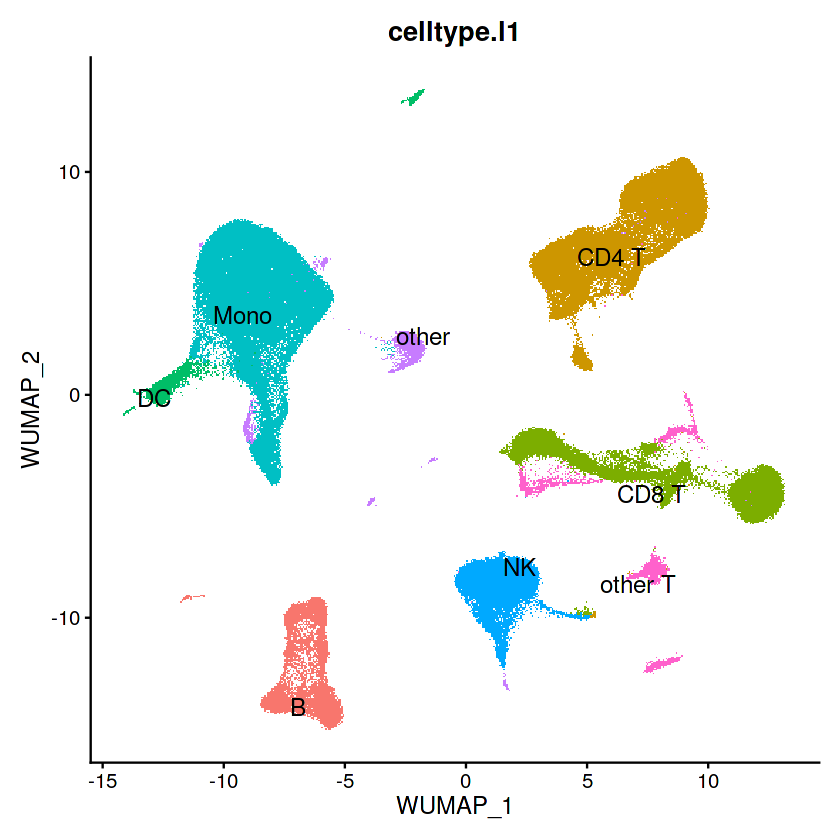

In [13]:
reference_plot_celltype.l1

In [13]:
# perfom sctransform on input scRNA-seq data

pbmc.rna <- SCTransform(pbmc.rna, verbose = FALSE)

In [14]:
pbmc.rna.anchors <- FindTransferAnchors(
  reference = reference,
  query = pbmc.rna,
  normalization.method = "SCT",
  reference.reduction = "spca",
  dims = 1:50
)

Normalizing query using reference SCT model

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 5198 anchors



In [18]:
pbmc.rna <- MapQuery(
  anchorset = pbmc.rna.anchors,
  query = pbmc.rna,
  reference = reference,
  refdata = list(
    celltype.l1 = "celltype.l1",
    celltype.l2 = "celltype.l2",
    predicted_ADT = "ADT"
  ),
  reference.reduction = "spca", 
  reduction.model = "wnn.umap"
)

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Predicting cell labels

Transfering 228 features onto reference data


Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data

Computing nearest neighbors

Running UMAP projection

21:43:20 Read 10412 rows

21:43:20 Processing block 1 of 1

21:43:20 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 15

21:43:20 Initializing by weighted average of neighbor coordinates using 1 thread

21:43:20 Commencing optimization for 67 epochs, with 156180 positive edges

21:43:22 Finished



In [19]:
pbmc.rna

An object of class Seurat 
36868 features across 10412 samples within 4 assays 
Active assay: RNA (36601 features, 2000 variable features)
 3 other assays present: prediction.score.celltype.l1, prediction.score.celltype.l2, predicted_ADT
 4 dimensional reductions calculated: pca, umap, ref.spca, ref.umap

Saving 6.67 x 6.67 in image



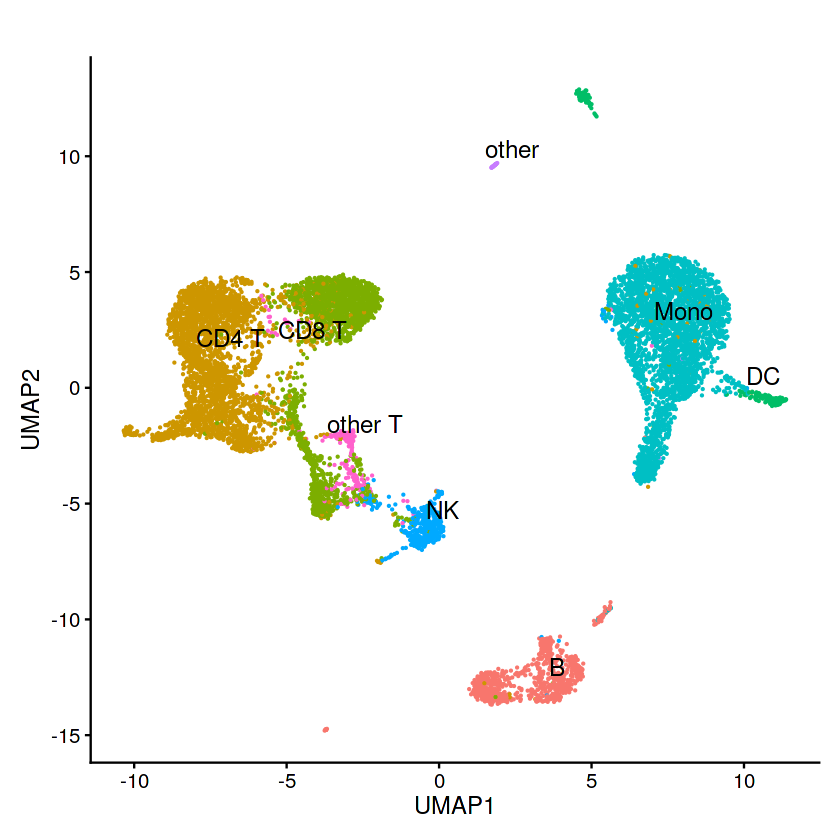

In [21]:
PBMC_scRNA_labelTransfer_from_CITE_seq_Seuratv4= DimPlot(pbmc.rna, reduction = "umap", group.by = "predicted.celltype.l1", label = TRUE, label.size = 5, repel = TRUE) + NoLegend() +  xlab("UMAP1") + ylab("UMAP2")+labs(title = ' ')
PBMC_scRNA_labelTransfer_from_CITE_seq_Seuratv4
ggsave(paste(figures_dir,"PBMC_scRNA_labelTransfer_from_CITE_seq_Seuratv4.png", sep=''))

Saving 6.67 x 6.67 in image



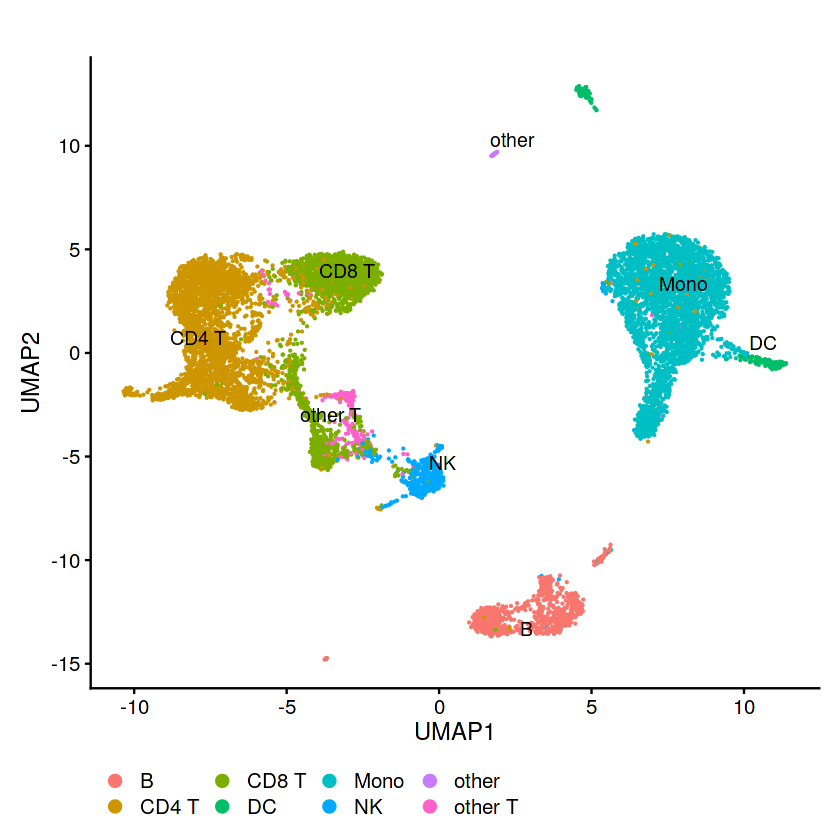

In [22]:
rna_plot <- DimPlot(pbmc.rna, reduction = 'umap', group.by = 'predicted.celltype.l1', label = TRUE, 
              repel = TRUE, label.size = 4)  +  xlab("UMAP1") + ylab("UMAP2")+labs(title = ' ')
rna_plot <- rna_plot + scale_fill_continuous(guide = guide_legend()) +
    theme(legend.position="bottom")
rna_plot
ggsave(paste(figures_dir,"rna_label_transfer.png", sep=''))


### export RNA label transfer results

In [26]:
write.csv(pbmc.rna@meta.data, paste(results_dir,"pbmc_rna_metaData_w_predictions.csv",sep=''))

## scATAC-seq annotation

#### it is recommended that gene activity matrix is only exposed to logtransformation: https://github.com/stuart-lab/signac/discussions/510 +  https://github.com/stuart-lab/signac/issues/433

In [27]:
reference

An object of class Seurat 
20957 features across 161764 samples within 2 assays 
Active assay: SCT (20729 features, 5000 variable features)
 1 other assay present: ADT
 6 dimensional reductions calculated: apca, aumap, pca, spca, umap, wnn.umap

In [28]:
logTransformedRNA <- CreateAssayObject(counts = reference@assays$SCT@counts)

In [29]:
reference[["logTransformedRNA"]] <- logTransformedRNA

In [30]:
DefaultAssay(reference) <- "logTransformedRNA"

In [31]:
reference

An object of class Seurat 
41686 features across 161764 samples within 3 assays 
Active assay: logTransformedRNA (20729 features, 0 variable features)
 2 other assays present: SCT, ADT
 6 dimensional reductions calculated: apca, aumap, pca, spca, umap, wnn.umap

In [32]:
reference <- NormalizeData(
  reference,
  normalization.method = "LogNormalize")

In [33]:
reference@assays$logTransformedRNA

Assay data with 20729 features for 161764 cells
First 10 features:
 AL627309.1, AL669831.5, LINC00115, FAM41C, NOC2L, KLHL17, PLEKHN1,
AL645608.8, HES4, ISG15 

In [34]:
reference <- FindVariableFeatures(reference)
reference <- ScaleData(reference)
reference <- RunPCA(reference)
reference <- RunUMAP(reference, dims = 1:30)


Centering and scaling data matrix

PC_ 1 
Positive:  RPS27, ETS1, RPS12, IL32, CD3E, LTB, TRBC2, CD3D, IL7R, CD3G 
	   CD2, TRAC, SYNE2, ARL4C, TXNIP, CD7, TCF7, CD247, CD69, SPOCK2 
	   TRBC1, GZMM, RORA, BCL11B, LINC00861, CXCR4, MALAT1, IKZF3, CD27, ITM2A 
Negative:  FCN1, LYZ, CST3, MNDA, CTSS, SERPINA1, CYBB, FGL2, FTL, NCF2 
	   S100A9, VCAN, GRN, PSAP, TYMP, SPI1, FTH1, TNFAIP2, CSTA, CD14 
	   AIF1, MPEG1, LST1, CLEC7A, CFD, S100A8, CD68, MS4A6A, CSF3R, NAMPT 
PC_ 2 
Positive:  MALAT1, CD79A, MS4A1, RALGPS2, IGHM, TNFRSF13C, LINC00926, RPS12, BANK1, IGHD 
	   VPREB3, CD22, CD79B, AFF3, PAX5, TCL1A, FCRL1, BCL11A, BLK, SWAP70 
	   P2RX5, FAM129C, HLA-DOB, COBLL1, ADAM28, RPS27, FCER2, LINC02397, HLA-DQA1, HLA-DQB1 
Negative:  TUBB1, CAVIN2, PF4, GP9, GNG11, PPBP, SPARC, PRKAR2B, TREML1, CLU 
	   CMTM5, MPIG6B, ACRBP, ITGA2B, C2orf88, TMEM40, CTTN, MYL9, PTCRA, TSC22D1 
	   AC147651.1, NRGN, HIST1H2AC, MAP3K7CL, CLDN5, MTURN, MYLK, MMD, RAB27B, HIST1H3H 
PC_ 3 
Positive:  PRF1, N

In [35]:
reference <- RunSPCA(reference, reduction.key = "SPC_logTr_", assay = 'logTransformedRNA', graph = 'wsnn')


Computing sPCA transformation



In [36]:
reference <- FindNeighbors(
  object = reference,
  reduction = "spca",
  dims = 1:50,
  graph.name = "spca.annoy.neighbors", 
  k.param = 50,
  cache.index = TRUE,
  return.neighbor = TRUE,
  l2.norm = TRUE
)

Computing nearest neighbors

Only one graph name supplied, storing nearest-neighbor graph only



In [37]:
reference <- FindMultiModalNeighbors(
  reference, reduction.list = list("spca", "apca"), 
  dims.list = list(1:30, 1:18), modality.weight.name = "RNA.weight2", knn.graph.name = "wknn_logTr", snn.graph.name = "wsnn_logTr", weighted.nn.name = "weighted.nn_logTr",
)

Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.

Calculating kernel bandwidths

Finding multimodal neighbors

Constructing multimodal KNN graph

Constructing multimodal SNN graph



In [38]:
reference <- RunUMAP(reference, nn.name = "weighted.nn_logTr", reduction.name = "wnn.umap_logTr", reduction.key = "wnnUMAPlogTr_")


22:23:13 UMAP embedding parameters a = 0.9922 b = 1.112

22:23:16 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 20

22:23:24 Initializing from normalized Laplacian + noise (using irlba)

22:23:55 Commencing optimization for 200 epochs, with 5351556 positive edges

22:25:23 Optimization finished



In [39]:
reference <- FindClusters(reference, graph.name = "wsnn_logTr", algorithm = 3, resolution = 2, verbose = FALSE)

In [40]:
reference

An object of class Seurat 
41686 features across 161764 samples within 3 assays 
Active assay: logTransformedRNA (20729 features, 2000 variable features)
 2 other assays present: SCT, ADT
 7 dimensional reductions calculated: apca, aumap, pca, spca, umap, wnn.umap, wnn.umap_logTr

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



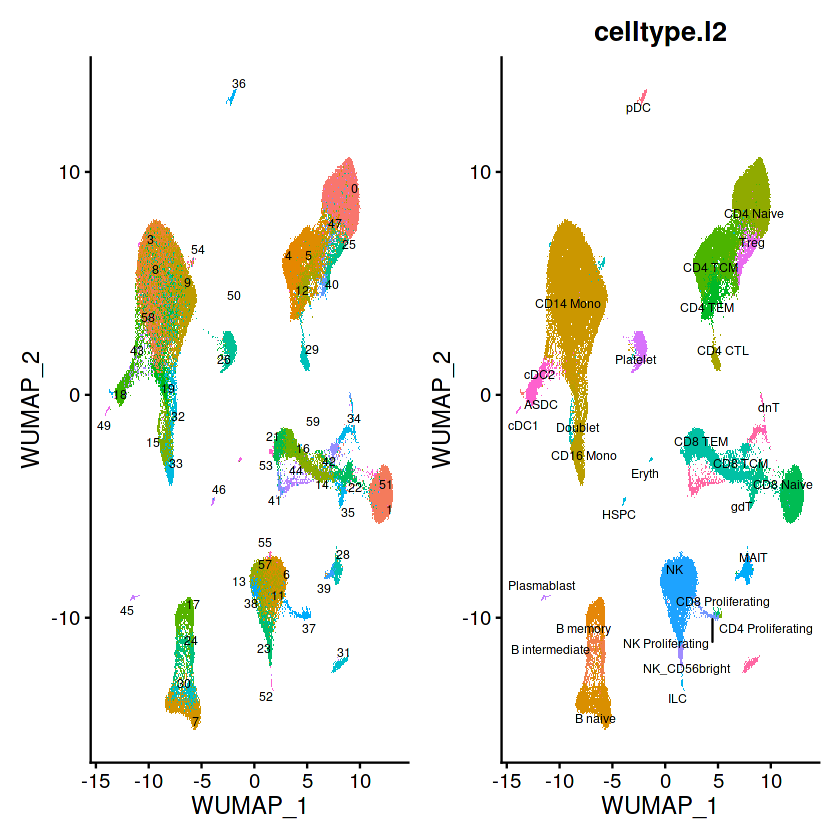

In [41]:
p1 <- DimPlot(reference, reduction = 'wnn.umap', label = TRUE, repel = TRUE, label.size = 2.5) + NoLegend()
p2 <- DimPlot(reference, reduction = 'wnn.umap', group.by = 'celltype.l2', label = TRUE, repel = TRUE, label.size = 2.5) + NoLegend()
p1 + p2

In [42]:
save.image(paste(results_dir , "WS/until_atac_annotation.RData", sep=''))

## process the query like reference

In [44]:
pbmc.atac

An object of class Seurat 
127984 features across 10412 samples within 2 assays 
Active assay: ACTIVITY (19607 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: lsi, umap.atac

In [45]:
pbmc.atac.anchors <- FindTransferAnchors(
  reference = reference,
  query = pbmc.atac,
  normalization.method = "LogNormalize",
  reference.reduction = "spca",
  dims = 1:50,
  k.filter = 30
)


Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 372 anchors

Filtering anchors

	Retained 5 anchors



### through the standard pipeline we retained only a small number of anchors, so we will try with cca now.. for CCA, we need variable feature:

In [46]:
pbmc.atac <- NormalizeData(pbmc.atac, normalization.method = "LogNormalize", scale.factor = 10000)

In [47]:
pbmc.atac <- FindVariableFeatures(pbmc.atac, selection.method = "vst", nfeatures = 3000)

In [48]:
pbmc.atac

An object of class Seurat 
127984 features across 10412 samples within 2 assays 
Active assay: ACTIVITY (19607 features, 3000 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: lsi, umap.atac

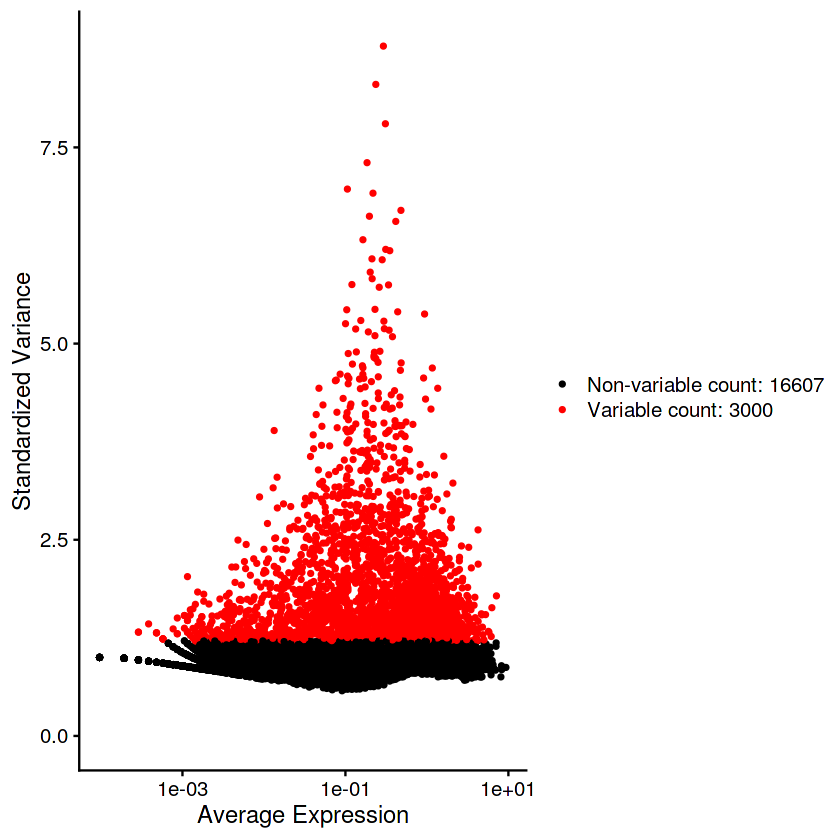

In [49]:
VariableFeaturePlot(pbmc.atac)

In [50]:
pbmc.atac.cca.anchors <- FindTransferAnchors(reference = reference, query = pbmc.atac, reduction = 'cca', dims = 1:30, 
                               reference.assay = 'logTransformedRNA', query.assay = 'ACTIVITY', normalization.method = 'LogNormalize')


Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 40982 anchors

Filtering anchors

	Retained 7622 anchors



In [51]:

saveRDS(pbmc.atac.cca.anchors, paste(results_dir , "WS/pbmc_atac_cca_anchors.rds", sep=''))

In [52]:
pbmc.atac <- TransferData(
  anchorset = pbmc.atac.cca.anchors, 
  reference = reference,
  query = pbmc.atac,
  refdata = list(
    celltype.l1 = "celltype.l1",
    celltype.l2 = "celltype.l2",
    predicted_ADT = "ADT"),
    weight.reduction = 'cca'
)

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Predicting cell labels

Transfering 228 features onto reference data



In [53]:
pbmc.atac <- IntegrateEmbeddings(
  anchorset = pbmc.atac.cca.anchors,
  reference = reference,
  query = pbmc.atac, 
  new.reduction.name = "ref.cca",
  reductions = "cca",
)


Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data



## export resulting annotations

In [54]:
atac_rna_predictions = data.frame(pbmc.atac@meta.data$predicted.celltype.l1, row.names =names(pbmc.atac$nCount_ACTIVITY) )

In [55]:
head(atac_rna_predictions)

,pbmc.atac.meta.data.predicted.celltype.l1
,<chr>
AAACAGCCAAGGAATC-1,CD4 T
AAACAGCCAATCCCTT-1,CD8 T
AAACAGCCAATGCGCT-1,CD8 T
AAACAGCCACCAACCG-1,Mono
AAACAGCCAGGATAAC-1,CD4 T
AAACAGCCAGTAGGTG-1,CD8 T


In [56]:
colnames(atac_rna_predictions) = c('atac.l1.predictions')

In [57]:
atac_rna_predictions['rna.l1.predictions'] = pbmc.rna@meta.data$predicted.celltype.l1

In [58]:
unique(atac_rna_predictions['rna.l1.predictions'])

,rna.l1.predictions
,<chr>
AAACAGCCAAGGAATC-1,CD4 T
AAACAGCCACCAACCG-1,CD8 T
AAACAGCCATCCAGGT-1,Mono
AAACATGCACCGGCTA-1,NK
AAACCGAAGTGAGCAA-1,other T
AAAGCAAGTTAACGGC-1,B
AAAGCACCATTGTGGC-1,DC
AACAAGCCAACCTAAT-1,other


In [59]:
write.csv(atac_rna_predictions,paste(results_dir , "10XPBMC_seurat_label_transfer_annotations.csv", sep='') )

In [60]:
pbmc.atac

An object of class Seurat 
128251 features across 10412 samples within 5 assays 
Active assay: ACTIVITY (19607 features, 3000 variable features)
 4 other assays present: ATAC, prediction.score.celltype.l1, prediction.score.celltype.l2, predicted_ADT
 3 dimensional reductions calculated: lsi, umap.atac, ref.cca

In [61]:
atac_plot <- DimPlot(pbmc.atac, reduction = 'umap.atac', group.by = 'predicted.celltype.l1', label = TRUE, 
              repel = TRUE, label.size = 4) #+ NoLegend()

In [62]:
reference_plot <- DimPlot(reference, reduction = "wnn.umap_logTr", group.by = "celltype.l1", label = TRUE, label.size = 4, repel = TRUE) 
ggsave(paste(figures_dir,"reference_plot.png", sep=''))

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Saving 6.67 x 6.67 in image



In [63]:
atac_plot <- atac_plot + scale_fill_continuous(guide = guide_legend()) +
    theme(legend.position="bottom")

ggsave(paste(figures_dir,"atac_label_transfer.png", sep=''))

Saving 6.67 x 6.67 in image



Saving 6.67 x 6.67 in image



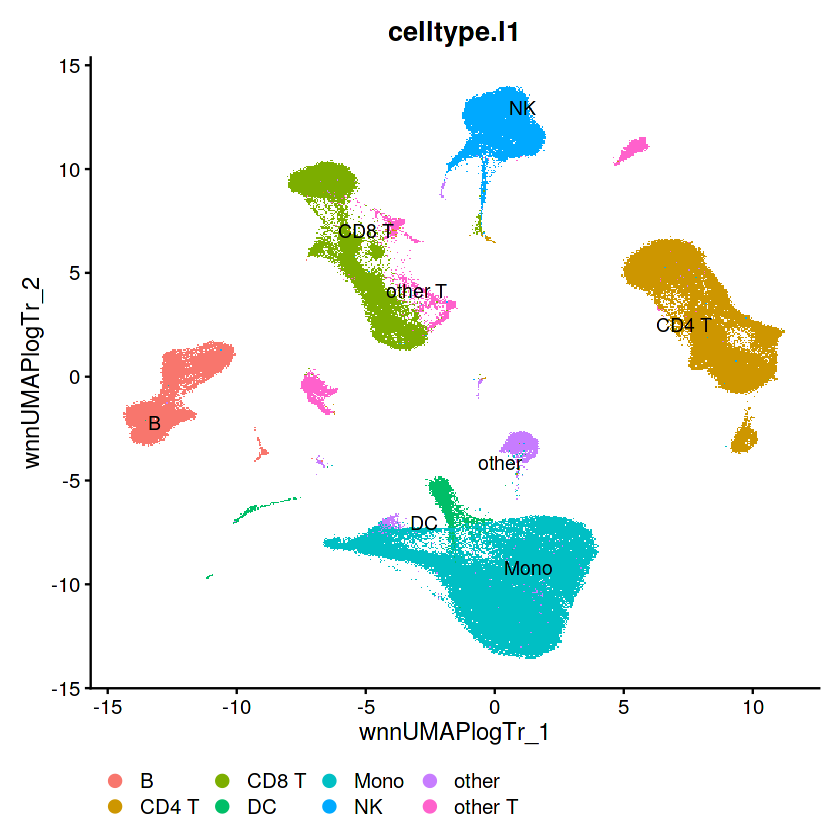

In [64]:
reference_plot + scale_fill_continuous(guide = guide_legend()) +
    theme(legend.position="bottom")
ggsave(paste(figures_dir,"reference_label_transfer.png", sep=''))


## export gene activity matrix for marker gene baased annottaion

In [67]:
write.csv(as.data.frame(gene.activities), paste(results_dir,"PBMC_atac_gene_activities.csv", sep=''))

In [69]:
write.csv(pbmc.atac@meta.data, paste(results_dir,"pbmc_atac_metaData_w_predictions.csv",sep=''))

In [70]:
save.image(paste(results_dir , "WS/completed.RData", sep=''))

In [ ]:
saveRDS(pbmc.atac , paste(results_dir ,"WS/pbmc_atac.RDS", sep='')
saveRDS(pbmc.rna, paste(results_dir ,"WS/pbmc_rna.RDS", sep='')
       